In [1]:
import pandas as pd
import numpy as np
from datetime import date
import missingno as msn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import country_converter as coco

# Set the global font to be Times New Roman
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 8 
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

### Data Cleaning
---

In [2]:
df = pd.read_csv("data/wdi_data.csv", low_memory=False)

In [3]:
col_names = ['country_name', 'country_code', 'date', 'date_code', 'adj_net_national_income_growth', 'adj_net_national_income_percap_growth', 'adj_net_saving_exl_gini', 'adj_net_saving_gross_gini', 'bank_capital_assets_ratio', 'bank_npl_ratio', 'brith_rate', 'bound_rate_all', 'bound_rate_manufacturing', 'bribery_incidence', 'broad_money_gdp', 'broad_money_growth', 'central_gov_debt_gdp', 'co2_emission', 'co2_intensity', 'cpi', 'current_account_balance_gdp', 'employment_population', 'export_value', 'export_volumne', 'export_goods_ser_gdp', 'export_goods_ser_growth', 'fdi_in_gdp', 'fdi_out_gdp', 'gdp', 'gdp_deflator', 'gdp_growth', 'gdp_percap', 'gdp_percap_growth', 'gini_index', 'gini_growth', 'gini_percap', 'gini_percap_growth', 'gross_capital_forma_gdp', 'gross_capital_forma_growth', 'gross_national_expen_gdp', 'gross_saving_gdp', 'hci', 'import_goods_ser_gdp', 'import_goods_ser_growth', 'industry_value_add_gdp', 'industry_value_add_growth', 'inflation_cpi', 'inflation_deflator', 'interests_expense', 'interests_revenue', 'interest_spread', 'labor_partici_15', 'labor_partici_15_64', 'femal_labor_total', 'lending_rate', 'net_lending_borrowing_gdp', '15_64_pop_total', '15_64_pop_femal', '15_64_pop_male', 'pop_growth', 'pop_density', 'femal_pop_total', 'tariff_all', 'tariff_manufacturing', 'tariff_primary', 'tax_rev_gdp', 'trade_gdp', 'unemployment_female', 'umemployment_male', 'umempoyment_total']

# Rename the columns
df.columns = col_names

In [4]:
# choose only OECD countries
oecd_countries_iso3 = [
    "AUS", "AUT", "BEL", "CAN", "CHL", "COL", "CRI", "CZE", "DNK", "EST", 
    "FIN", "FRA", "DEU", "GRC", "HUN", "ISL", "IRL", "ISR", "ITA", "JPN", 
    "KOR", "LVA", "LTU", "LUX", "MEX", "NLD", "NZL", "NOR", "POL", "PRT", 
    "SVK", "SVN", "ESP", "SWE", "CHE", "TUR", "GBR", "USA"
]

df = df[df['country_code'].isin(oecd_countries_iso3)]

# convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y').dt.year

# replace '..' with np.nan
df = df.replace('..', np.nan)

# Convert columns to numeric starting from the 4th column
df.iloc[:, 4:] = df.iloc[:, 4:].astype(float).round(3)

# drop columns
df = df.drop(columns=['date_code'])

# choose time period 1992 - 2022
df = df[(df['date'] >= 1992) & (df['date'] <= 2022)]

# gen variable fdi net flow
df['fdi_net_flow'] = df['fdi_in_gdp'] - df['fdi_out_gdp']
# drop fdi_in_gdp and fdi_out_gdp
df = df.drop(columns=['fdi_in_gdp', 'fdi_out_gdp'])

# if country has missing value in fdi_net_flow, drop the country
df = df.groupby('country_name').filter(lambda x: x['fdi_net_flow'].notna().all())

# add the treated column
df['treated_group'] = np.where(df['country_code'] == 'GBR', 1, 0)
# add post period column
df['post_period'] = np.where(df['date'] >= 2017, 1, 0)
# add treated post column
df['treated'] = df['treated_group'] * df['post_period']

In [5]:
# reset index
df.reset_index(drop=True, inplace=True)

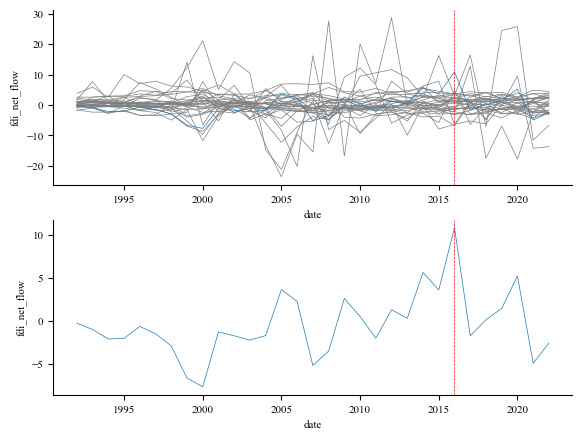

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df.query("treated_group==0"), x='date', y='fdi_net_flow', ax=ax[0], units='country_code', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=df.query("treated_group==1"), x='date', y='fdi_net_flow', ax=ax[0], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[0].axvline(2016, color='red', linestyle='--', linewidth=0.5)
sns.lineplot(data=df.query("treated_group==1"), x='date', y='fdi_net_flow', ax=ax[1], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[1].axvline(2016, color='red', linestyle='--', linewidth=0.5)

sns.despine()

In [7]:
# drop variables that have more than 70% missing values
df_dropna = df.dropna(thresh=len(df) * 0.7, axis=1).copy()
# reset index
df_dropna.reset_index(drop=True, inplace=True)

In [17]:
df_dropna

,country_name,country_code,date,adj_net_national_income_growth,adj_net_national_income_percap_growth,adj_net_saving_exl_gini,adj_net_saving_gross_gini,brith_rate,bound_rate_all,bound_rate_manufacturing,...,trade_gdp,unemployment_female,umemployment_male,umempoyment_total,fdi_net_flow,treated_group,post_period,treated,const,tr_group
0,Australia,AUS,1992,NaN,NaN,3.238,19.075,15.1,NaN,NaN,...,33.045,9.936,11.305,10.733,0.34,0,0,0,1,0
1,Australia,AUS,1993,NaN,NaN,5.767,20.886,14.7,NaN,NaN,...,35.4,10.005,11.509,10.879,0.886,0,0,0,1,0
2,Australia,AUS,1994,NaN,NaN,7.715,22.368,14.5,NaN,NaN,...,36.459,9.37,9.983,9.724,0.815,0,0,0,1,0
3,Australia,AUS,1995,NaN,NaN,6.653,21.374,14.2,NaN,NaN,...,37.704,8.111,8.743,8.473,2.505,0,0,0,1,0
4,Australia,AUS,1996,NaN,NaN,7.821,21.668,13.9,9.68,11.82,...,38.233,8.24,8.711,8.509,-0.11,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,United States,USA,2018,2.909,2.369,6.847,19.338,11.6,3.62,3.46,...,27.445,3.837,3.946,3.896,1.672,0,1,0,1,0
957,United States,USA,2019,2.263,1.798,6.885,19.45,11.4,3.62,3.46,...,26.278,3.609,3.721,3.669,0.934,0,1,0,1,0
958,United States,USA,2020,-3.431,-4.362,5.759,19.043,10.9,3.62,3.46,...,23.105,8.35,7.802,8.055,-0.695,0,1,0,1,0
959,United States,USA,2021,5.227,5.061,4.37,17.868,11.0,3.62,3.46,...,25.253,5.213,5.466,5.349,0.42,0,1,0,1,0


<Axes: >

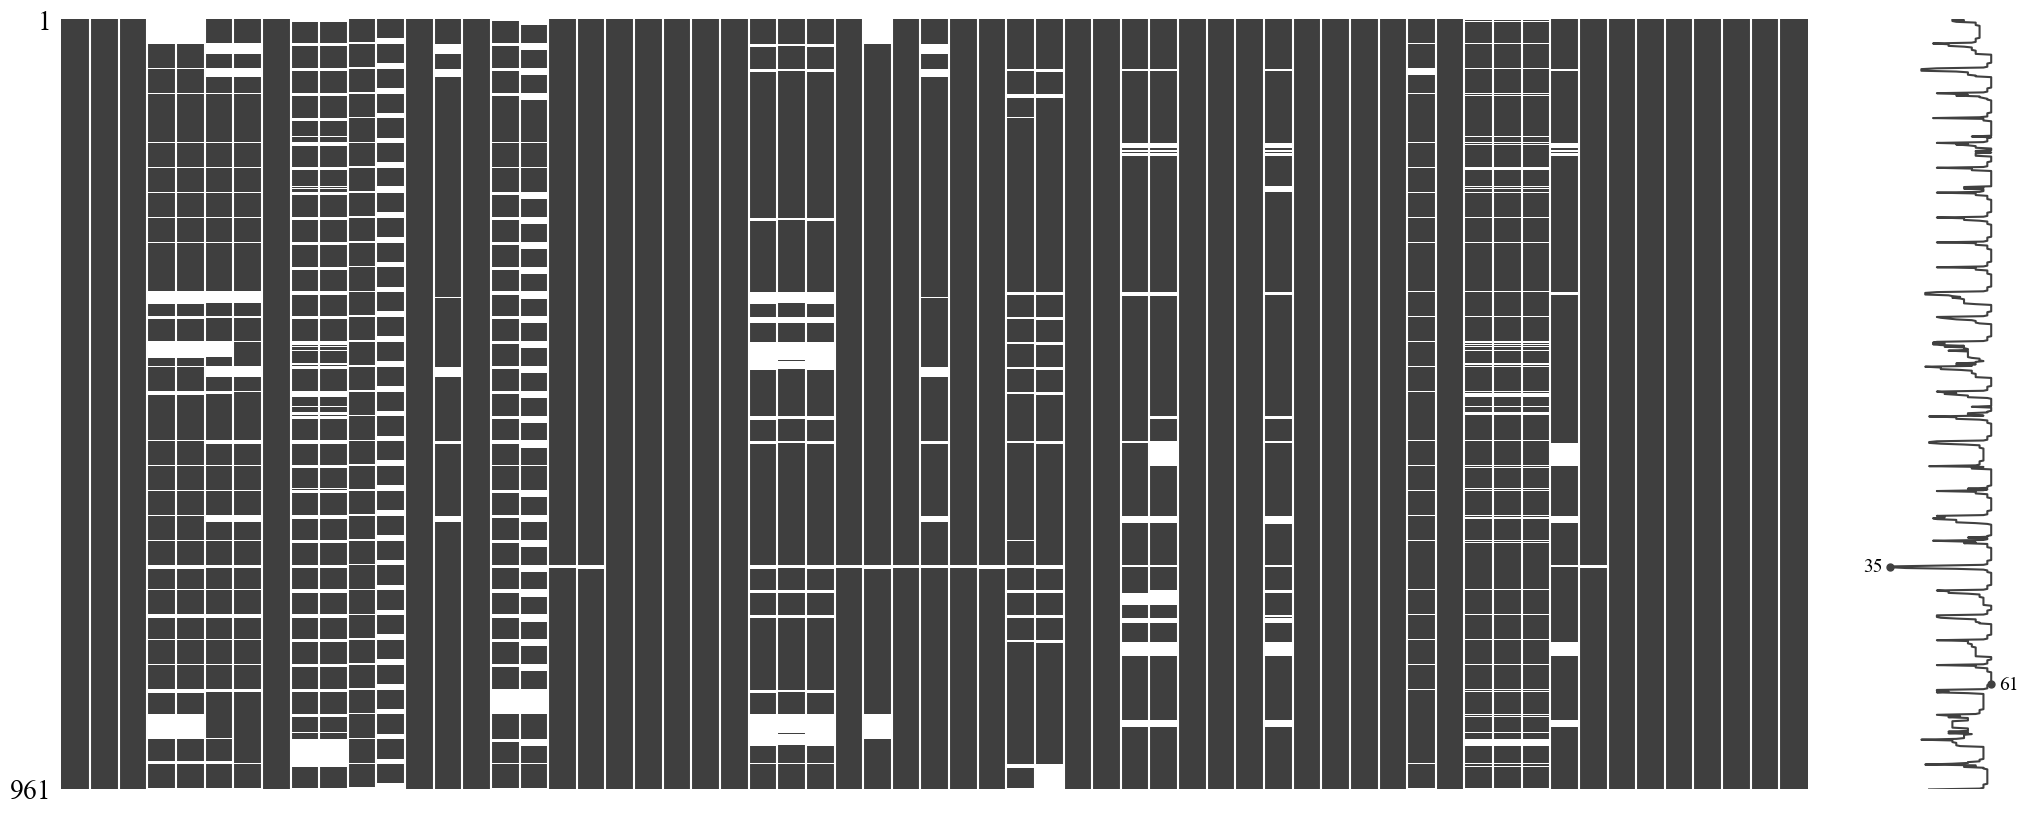

In [8]:
msn.matrix(df_dropna)

<Axes: >

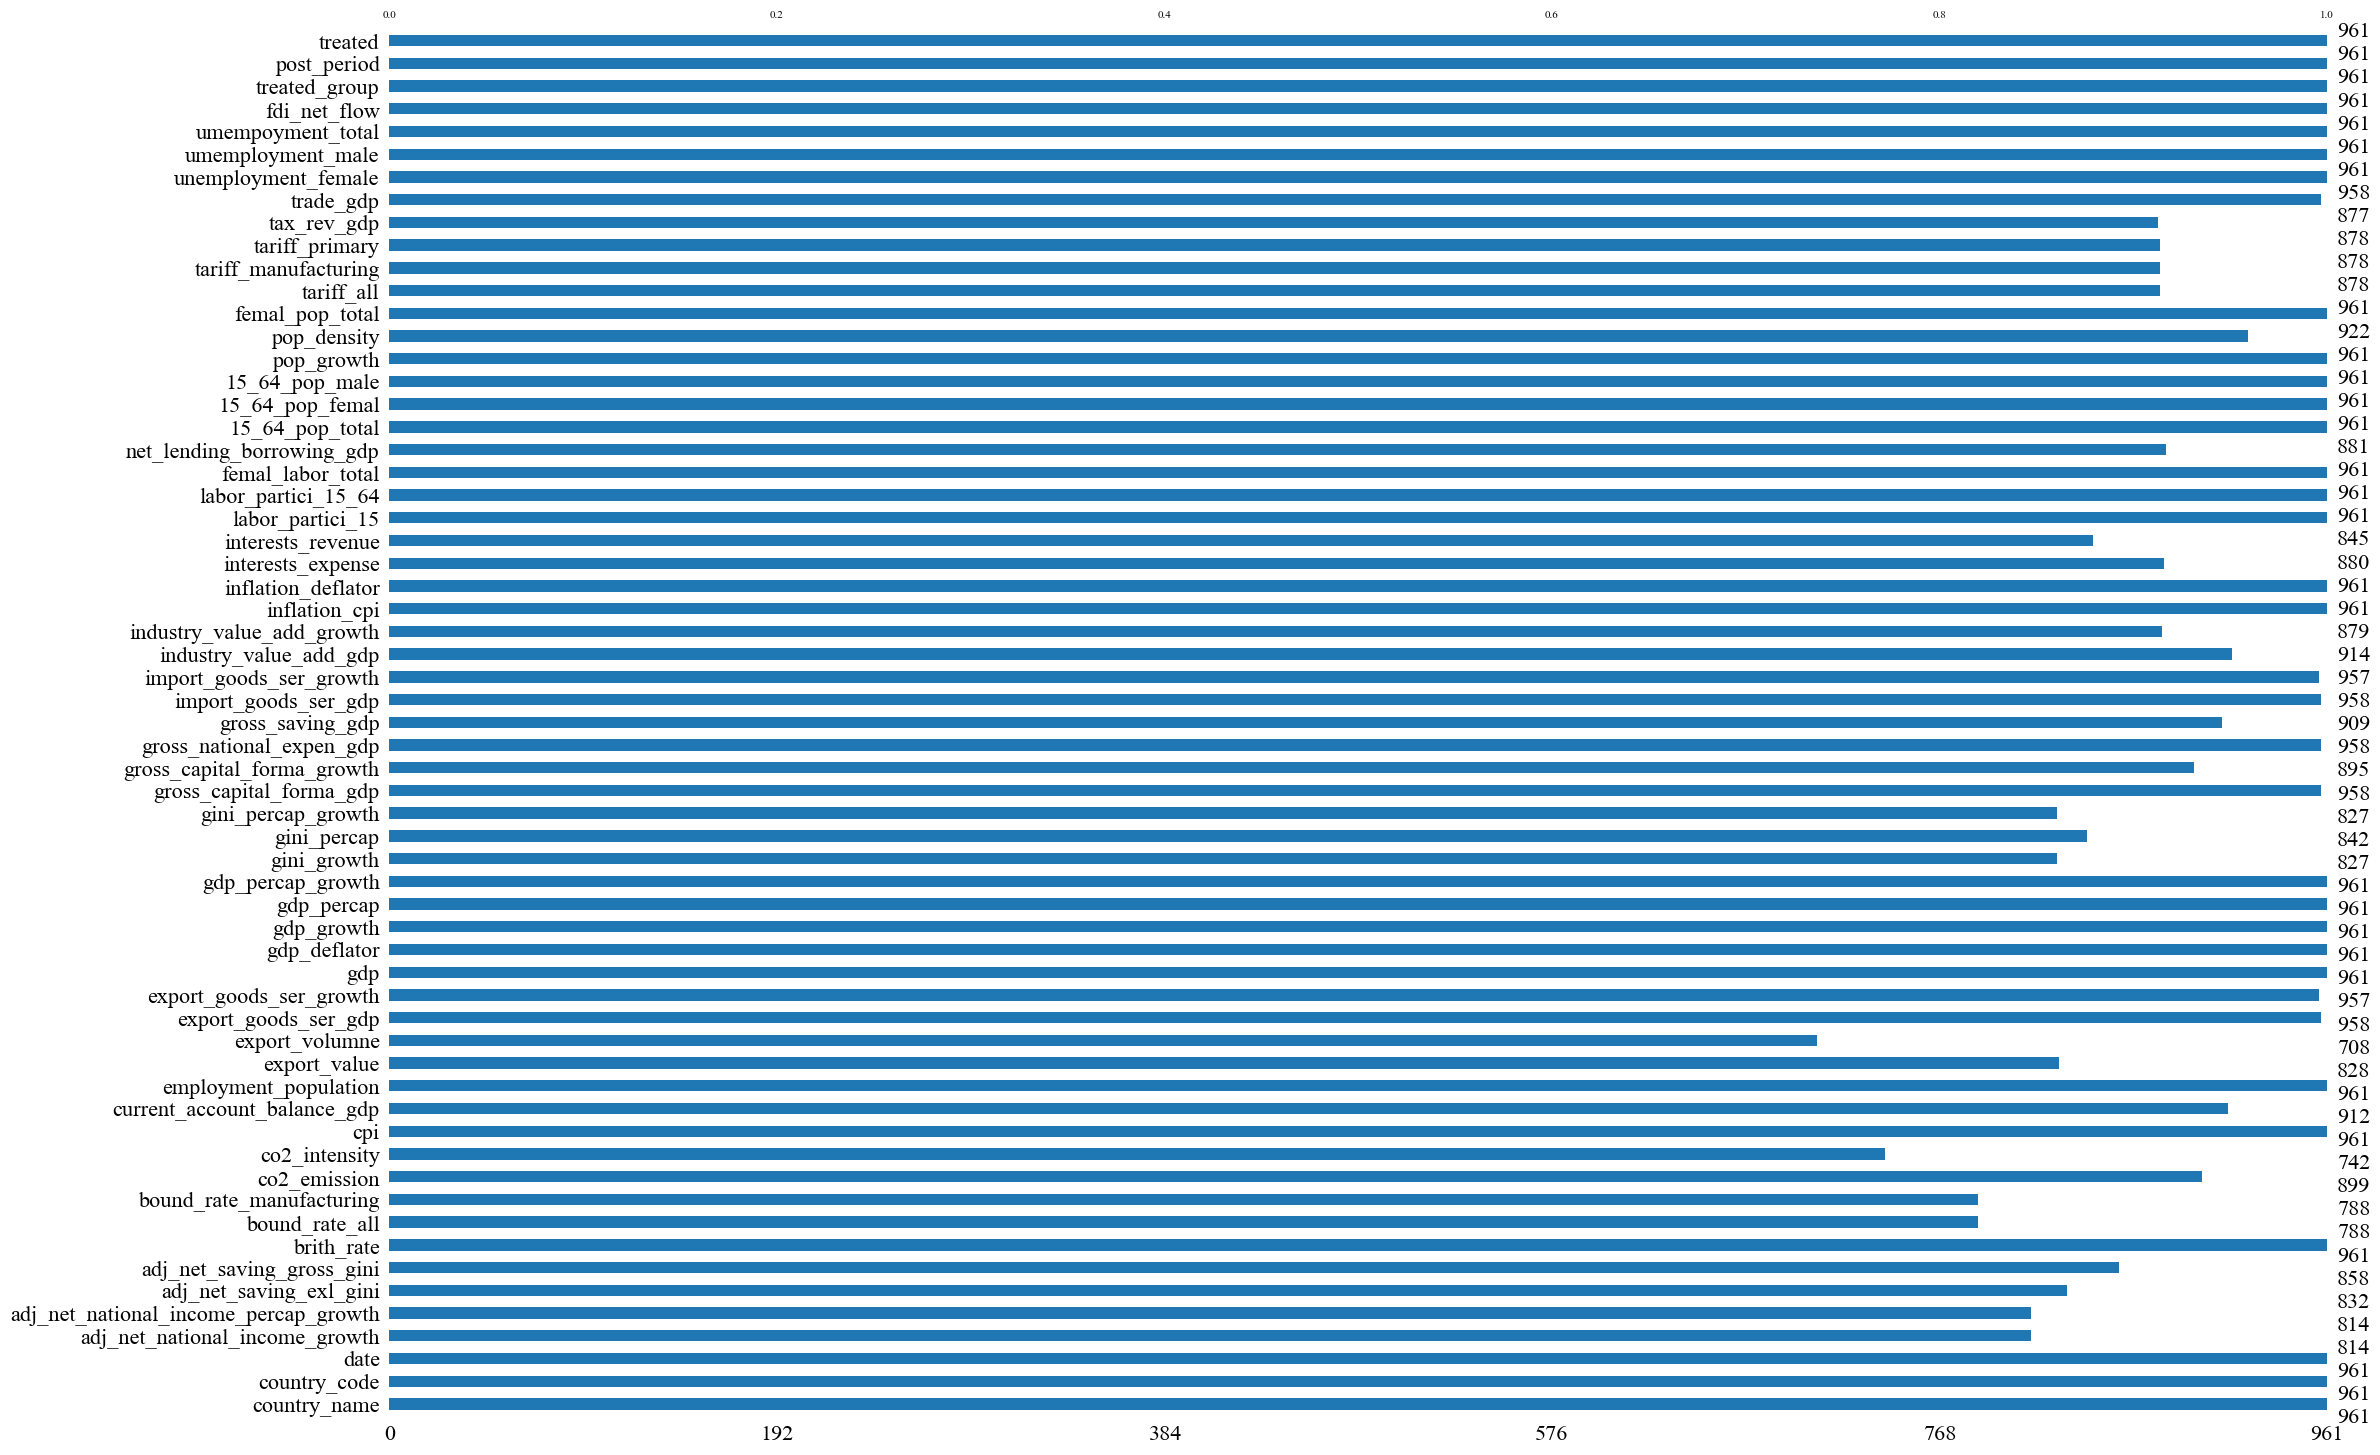

In [9]:
msn.bar(df_dropna, color=colors[0])

In [10]:
df.shape, df_dropna.shape

((961, 71), (961, 61))

In [11]:
df_dropna.columns

Index(['country_name', 'country_code', 'date',
       'adj_net_national_income_growth',
       'adj_net_national_income_percap_growth', 'adj_net_saving_exl_gini',
       'adj_net_saving_gross_gini', 'brith_rate', 'bound_rate_all',
       'bound_rate_manufacturing', 'co2_emission', 'co2_intensity', 'cpi',
       'current_account_balance_gdp', 'employment_population', 'export_value',
       'export_volumne', 'export_goods_ser_gdp', 'export_goods_ser_growth',
       'gdp', 'gdp_deflator', 'gdp_growth', 'gdp_percap', 'gdp_percap_growth',
       'gini_growth', 'gini_percap', 'gini_percap_growth',
       'gross_capital_forma_gdp', 'gross_capital_forma_growth',
       'gross_national_expen_gdp', 'gross_saving_gdp', 'import_goods_ser_gdp',
       'import_goods_ser_growth', 'industry_value_add_gdp',
       'industry_value_add_growth', 'inflation_cpi', 'inflation_deflator',
       'interests_expense', 'interests_revenue', 'labor_partici_15',
       'labor_partici_15_64', 'femal_labor_total', 'ne

In [12]:
# save the data
df_dropna.to_csv('data/wdi_data_cleaned.csv', index=False)

### Empirical study
---

In [13]:
from src.csc_ipca import CSC_IPCA
from src.csc_ife import CSC_IFE
from src.scm import SCM

In [14]:
# gen a list of covariates
covariates = df_dropna.columns[4:-4].tolist() + ['const']
# add the constant term
df_dropna['const'] = 1

In [15]:
df_dropna.fdi_net_flow.dtype

dtype('O')

In [16]:
# instantiate the model
model = CSC_IPCA()
# set the number of principal components
K = 1
# fit the model
model.fit(df_dropna, 'country_name', 'date', 'fdi_net_flow', 'treated', covariates, K)

ValueError: array must not contain infs or NaNs